In [1]:

import xarray as xr
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import sys
sys.path.append('/scratch/nf33/sc5932/hk25-AusNode-TConvZones/functions')
from SC_function import get_nn_lon_lat_index

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [2]:
mean_era5_loaded = xr.open_dataset('/scratch/nf33/sc5932/Data/regridded/mean_era5.nc').tp

t_lon = mean_era5_loaded['longitude'].values
t_lat = mean_era5_loaded['latitude'].values


In [3]:
path = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/amip/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_amip_r1i1p1f1_gn_19790101-20141231.nc'

ds_access_amip = xr.open_dataset(path)
ds_access_amip.pr

<xarray.DataArray 'pr' (time: 13149, lat: 145, lon: 192)> Size: 1GB
[366068160 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 105kB 1979-01-01T12:00:00 ... 2014-12-31T1...
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-14T05:11:11Z altered by CMOR: replaced missing va...

## annual mean

In [4]:
time_start = "2007-03-01"
time_end = "2008-02-28"
mean_access = (ds_access_amip.pr.sel(time=slice(time_start , time_end))*86400).mean(dim ='time')
mean_access = mean_access.assign_coords(
    lon=(((mean_access.lon + 180) % 360) - 180)
).sortby('lon')


In [5]:
from cartopy.util import add_cyclic_point

change_map_cyc, lon_cyc = add_cyclic_point(mean_access, coord=mean_access.lon)


df_hist = xr.DataArray(change_map_cyc, coords=[mean_access.lat, lon_cyc],
                                    dims=['latitude', 'longitude'],
                                    name='pr', attrs={'units': 'mm/day'})
        


In [6]:
mean_access_aligned = df_hist.interp(
    latitude=t_lat,
    longitude=t_lon,
    method="linear"  # or "nearest", "cubic" if supported
)

In [7]:
mean_access_aligned.to_netcdf('/scratch/nf33/sc5932/Data/regridded/mean_access_amip_aligned.nc')


## seasonal

In [ ]:
time_start = "2007-03-01"
time_end = "2008-02-28"
mean_access = (ds_access_amip.pr.sel(time=slice(time_start , time_end))*86400).groupby('time.season').mean(dim ='time')

mean_access = mean_access.assign_coords(
    lon=(((mean_access.lon + 180) % 360) - 180)
).sortby('lon')



In [ ]:
cyclic_data, cyclic_lon = add_cyclic_point(mean_access.values, coord=mean_access.lon)

# Now create a new DataArray with updated longitude
mean_access_cyclic = xr.DataArray(
    cyclic_data,
    dims=["season", "lat", "lon"],
    coords={
        "season": mean_access.season,
        "lat": mean_access.lat,
        "lon": cyclic_lon
    },
    name="pr",
    attrs=mean_access.attrs
)

In [14]:
mean_access_aligned = df_hist.interp(
    latitude=t_lat,
    longitude=t_lon,
    method="linear"  # or "nearest", "cubic" if supported
)

In [23]:
mean_access_cyclic

<xarray.DataArray 'pr' (season: 4, lat: 145, lon: 193)> Size: 448kB
array([[[0.16864458, 0.16864458, 0.16864458, ..., 0.16864458,
         0.16864458, 0.16864458],
        [0.19670482, 0.19427428, 0.19349845, ..., 0.19820397,
         0.19723882, 0.19670482],
        [0.07687645, 0.08011452, 0.08538433, ..., 0.07131288,
         0.07312313, 0.07687645],
        ...,
        [0.3818138 , 0.37931034, 0.36699072, ..., 0.3908597 ,
         0.3875276 , 0.3818138 ],
        [0.4251578 , 0.42071855, 0.41554278, ..., 0.426933  ,
         0.42454606, 0.4251578 ],
        [0.5072272 , 0.5072272 , 0.5072272 , ..., 0.5072272 ,
         0.5072272 , 0.5072272 ]],

       [[0.24281967, 0.24281967, 0.24281967, ..., 0.24281967,
         0.24281967, 0.24281967],
        [0.19825467, 0.19717608, 0.19629884, ..., 0.19990432,
         0.19896479, 0.19825467],
        [0.08347256, 0.08759852, 0.0925044 , ..., 0.08157834,
         0.08157366, 0.08347256],
...
        [0.68893105, 0.6943533 , 0.6959603 , ..., 0.68265283,
         0.68514055, 0.68893105],
        [0.68579304, 0.69192225, 0.69014406, ..., 0.6800704 ,
         0.68039286, 0.68579304],
        [0.62606543, 0.62606543, 0.62606543, ..., 0.62606543,
         0.62606543, 0.62606543]],

       [[0.17485937, 0.17485937, 0.17485937, ..., 0.17485937,
         0.17485937, 0.17485937],
        [0.1959573 , 0.19693767, 0.19756651, ..., 0.19156002,
         0.19279994, 0.1959573 ],
        [0.08746813, 0.09259021, 0.09997396, ..., 0.08231653,
         0.08451176, 0.08746813],
        ...,
        [0.7313233 , 0.7276358 , 0.72147053, ..., 0.73358434,
         0.729793  , 0.7313233 ],
        [0.74250764, 0.7455021 , 0.7474077 , ..., 0.7412613 ,
         0.7415985 , 0.74250764],
        [0.74866164, 0.74866164, 0.74866164, ..., 0.74866164,
         0.74866164, 0.74866164]]], shape=(4, 145, 193), dtype=float32)
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB -180.0 -178.1 -176.2 -174.4 ... 176.2 178.1 180.0

In [24]:
season_access_aligned = mean_access_cyclic.interp(
    lat=t_lat,
    lon=t_lon,
    method="linear"  # or "nearest", "cubic" if supported
)

In [18]:
mean_access_aligned.to_netcdf('/scratch/nf33/sc5932/Data/regridded/mean_access_amip_aligned.nc')

PermissionError: [Errno 13] Permission denied: '/scratch/nf33/sc5932/Data/regridded/mean_access_amip_aligned.nc'

Text(0.5, 1.0, 'UM Daily Mean Precipitation from Feb 2020 to March 2021')

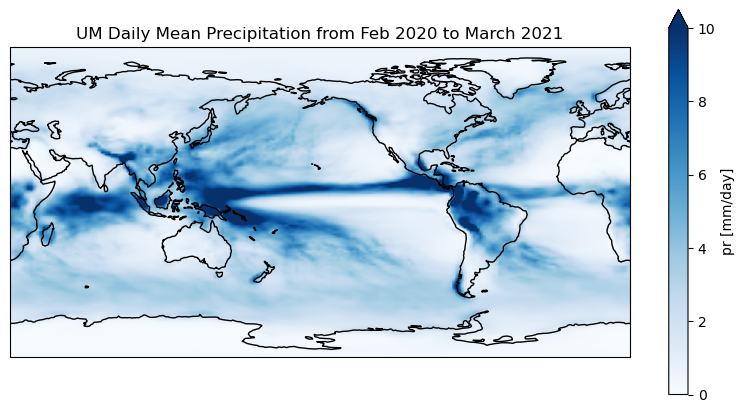

In [15]:
import cartopy.crs as ccrs

projection = ccrs.PlateCarree(central_longitude=205)
fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
mean_access_aligned.plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM Daily Mean Precipitation from Feb 2020 to March 2021')